## Convolutional neural networks - classifying handwritten numbers

#### $\textbf{Goal}:$ Using the MNIST dataset, containing about 70000 28x28 black and white images of handwritten numbers, the goal of this exercise is to correctly classify these images using a CNN.

$\textbf{Background}:$ Convolutional Neural Networks (CNNs) are a specialized class of deep learning models designed to process and analyze visual data, making them ideal for image classification tasks. Unlike traditional neural networks, CNNs use a combination of convolutional layers, pooling layers, and fully connected layers to automatically learn hierarchical features from input images.

Convolutional Layers: These layers apply filters (also called kernels) that slide over the input image, capturing spatial hierarchies by detecting local patterns such as edges, textures, and corners. Each filter extracts specific features, which become more abstract in deeper layers. This operation reduces the image's dimensionality while preserving its important features.

Pooling Layers: After convolution, pooling layers reduce the spatial dimensions of the feature maps, which helps in minimizing computation and preventing overfitting. Max pooling is commonly used, which keeps only the most important features (maximum values) from each region.

Fully Connected Layers: Toward the end of the network, the extracted features are flattened and passed through fully connected layers, where every node is connected to every other node in the next layer. These layers perform the final classification based on the learned features.

![Image of Yaktocat](https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

***

Author: Simon Guldager

Date: October 19, 2024

In [1]:
# Import standard libraries:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Import tensorflow and keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# Load the MNIST data set using Keras
from keras.datasets import mnist

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler
## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

In [2]:
def plot_training_results(history):

    # make a list of the train and val metrics
    metrics = list(history.history.keys())
    
    # make lists of train and val metrics
    val_metrics = [entry for entry in metrics if entry.startswith('val_')]
    train_metrics = [entry for entry in metrics if not entry.startswith('val_')]

    # the number of metrics to plot
    Nmetrics = len(val_metrics)
    width = 5 * Nmetrics

    fig, ax = plt.subplots(ncols = Nmetrics, figsize=(width, 5))

    # plot the train and val results for each metric
    for i, axx in enumerate(ax):
        ax[i].plot(history.history[train_metrics[i]], label='train', alpha = 0.7)  
        ax[i].plot(history.history[val_metrics[i]], label='validation', alpha = 0.7)
        ax[i].set_ylabel(f'{train_metrics[i].replace("_"," ").capitalize()}')
        ax[i].set_xlabel('Epoch')
        ax[i].legend(loc='best')
    fig.tight_layout()
    return fig, ax 

## Data exploration

Load the MNIST dataset and split it into traning, validation and test data

In [3]:
# load the data, split between train and testval sets
(train_images, train_labels), (testval_images, testval_labels) = mnist.load_data()

# define image dimensions. img_channels = 1 for grayscale images
img_rows, img_cols, img_channels = train_images.shape[1], train_images.shape[2], 1

# split testval set into specific test and validation set
val_images, test_images, val_labels, test_labels = train_test_split(
    testval_images, testval_labels, test_size=0.2, random_state=42
    )

Let's have a look at the first 15 images

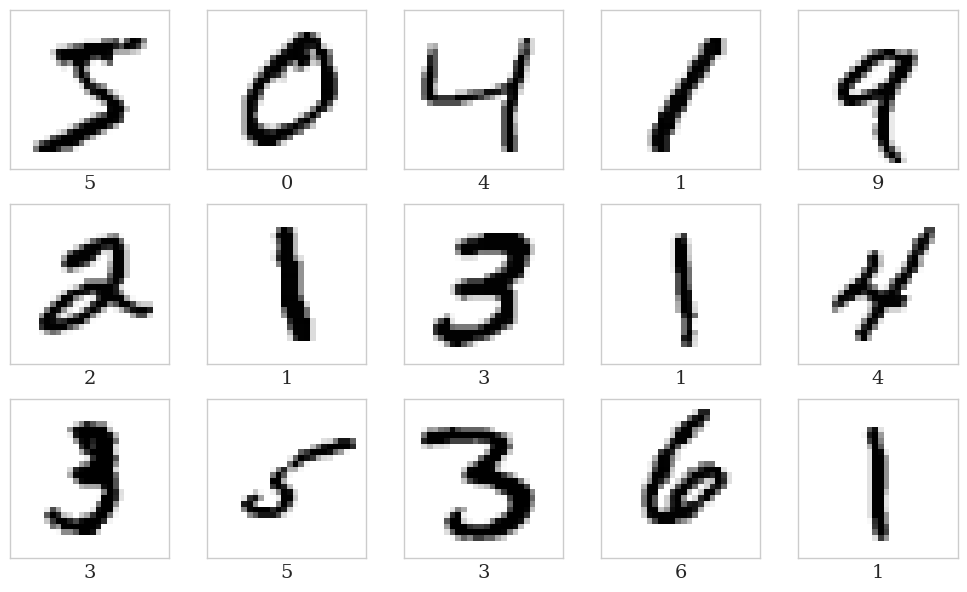

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10,6))
ax = ax.flatten()
for i in range(len(ax)):
    # Display an image
    ax[i].imshow(train_images[i], cmap=plt.cm.binary)
    ax[i].set(xlabel = (train_labels[i]), xticks = [], yticks = [])
    ax[i].grid(False)   
    
plt.tight_layout()

Each pixel can take a value between 0 and 255, the former being white and the latter black. Let's plot the pixel distribution for all training images as a histogram

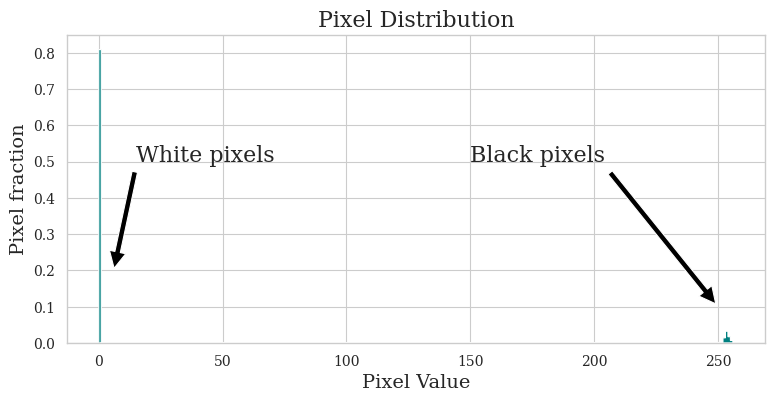

In [5]:
fig, ax = plt.subplots(figsize=(9,4))
ax.hist(train_images.flatten(), bins=256, range=(0,256), density=True, color='teal', histtype='stepfilled',);
ax.set(xlabel='Pixel Value', ylabel='Pixel fraction', title='Pixel Distribution')

# make arrow to show threshold
ax.annotate('White pixels', xy=(6, 0.2), xytext=(15, .5),
            arrowprops=dict(facecolor='black', shrink=0.02), fontsize=16
            )
ax.annotate('Black pixels', xy=(250, 0.1), xytext=(150, .5),
            arrowprops=dict(facecolor='black', shrink=0.02), fontsize=16
            );

In [6]:
# calculate fraction of white and black pixels
white_pixel_fraction = (train_images.flatten() < 5).sum() / len(train_images.flatten())
black_pixel_fraction = (train_images.flatten() > 250).sum() / len(train_images.flatten())
print(f"Fraction of black pixels: {black_pixel_fraction:.2f}")
print(f"Fraction of white pixels: {white_pixel_fraction:.2f}")
print(f"Fraction of gray pixels: {1 - black_pixel_fraction - white_pixel_fraction:.2f}")

Fraction of black pixels: 0.07
Fraction of white pixels: 0.81
Fraction of gray pixels: 0.12


## Data preprocessing

Standardize images and reshape images into the appropriate format for tensorflow

In [7]:
# load the data, split between train and testval sets
(train_images, train_labels), (testval_images, testval_labels) = mnist.load_data()

# define image dimensions. img_channels = 1 for grayscale images
img_rows, img_cols, img_channels = train_images.shape[1], train_images.shape[2], 1

# split testval set into specific test and validation set
val_images, test_images, val_labels, test_labels = train_test_split(
    testval_images, testval_labels, test_size=0.2, random_state=42
    )

# define function to standardize pixel values
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save mean and standard deviation of training data for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# standardize test data using training mean and standard deviation
# to ensure unbiased estimate of real model performance
test_images = standardizeimg(img=test_images, mu=mu_train, sigma=sigma_train)

# adapt to format required by tensorflow, i.e. (n_samples, img_rows, img_cols, n_channels)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, img_channels)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, img_channels)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, img_channels)

# convert label vectors using one hot encoding
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# print shapes of training, validation and test sets
print("Training set image shapes:", train_images.shape)
print("Training set labels shapes:", train_labels.shape)
print("\nValidation set image shapes:", val_images.shape)
print("Validation set labels shapes:", val_labels.shape)
print("\nTest set image shapes:", test_images.shape)
print("Test set labels shapes:", test_labels.shape)


Training set image shapes: (60000, 28, 28, 1)
Training set labels shapes: (60000, 10)

Validation set image shapes: (8000, 28, 28, 1)
Validation set labels shapes: (8000, 10)

Test set image shapes: (2000, 28, 28, 1)
Test set labels shapes: (2000, 10)


## Building, training, evaluating and optimizing a CNN

Below, we build a model that consists of 2 convolutional layers and 2 max pooling layers followed by a dense layer and an output layer (in line with the cnn illustration at the start). We have also included a dropout layer, which 'turns off' a fraction of random neurons determined by the rate parameter (i.e. in our case 5% of neurons) during each evaluation. This helps avoid overtraining.

Important parameters:
- Number of convolutional layers
- Number of pooling layers (typically but not necessarily, a pooling layer is added after a convolutional layer)
- Whether to use max or mean pooling
- Number of filters and kernel size of each convolutional layer
- Number of dropout layers (and dropout rate) if these layers are used
- Number and size of dense layers


In [33]:
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

# First pooling layer
model.add(MaxPooling2D(pool_size=2, strides=None))

# Second convolutional layer
model.add(Conv2D(filters=8,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

# Second pooling layer
model.add(MaxPooling2D(pool_size=2, strides=None))

# Dropout layer
model.add(Dropout(rate=0.05))

# Flatten layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=64, activation='relu'))

# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 8)         2312      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 8)           0         
                                                                 
 flatten_3 (Flatten)         (None, 392)              

Compile and train model. We use a large batch size and a small number of epochs to reduce training time.

In [34]:
# set the central parameters for compiling and training
learning_rate = 1e-5
epochs = 10
batch_size = 512

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['categorical_accuracy'])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(val_images, val_labels))

Epoch 1/10
118/118 [==============================] - 15s 119ms/step - loss: 2.2882 - categorical_accuracy: 0.1265 - val_loss: 2.2662 - val_categorical_accuracy: 0.1365
Epoch 2/10
118/118 [==============================] - 15s 128ms/step - loss: 2.2494 - categorical_accuracy: 0.1560 - val_loss: 2.2213 - val_categorical_accuracy: 0.1900
Epoch 3/10
118/118 [==============================] - 15s 127ms/step - loss: 2.2000 - categorical_accuracy: 0.2201 - val_loss: 2.1608 - val_categorical_accuracy: 0.2854
Epoch 4/10
118/118 [==============================] - 15s 130ms/step - loss: 2.1330 - categorical_accuracy: 0.3071 - val_loss: 2.0781 - val_categorical_accuracy: 0.3989
Epoch 5/10
118/118 [==============================] - 17s 143ms/step - loss: 2.0428 - categorical_accuracy: 0.4036 - val_loss: 1.9704 - val_categorical_accuracy: 0.5061
Epoch 6/10
118/118 [==============================] - 16s 138ms/step - loss: 1.9294 - categorical_accuracy: 0.4933 - val_loss: 1.8406 - val_categorical_acc

# Examine filters visually

To get a better intuition of what these filters look like, let's have a look. The filters can roughly speaking be thought of a small building blocks that each encodes a small image feature (e.g. the edge of some number). During training, the model will (hopefully) learn characteristic features of each number (or class in general). After training, it can extract the features of an image and use them to predict the number/class of the image.

1st 30 filters in convolution layer 1:


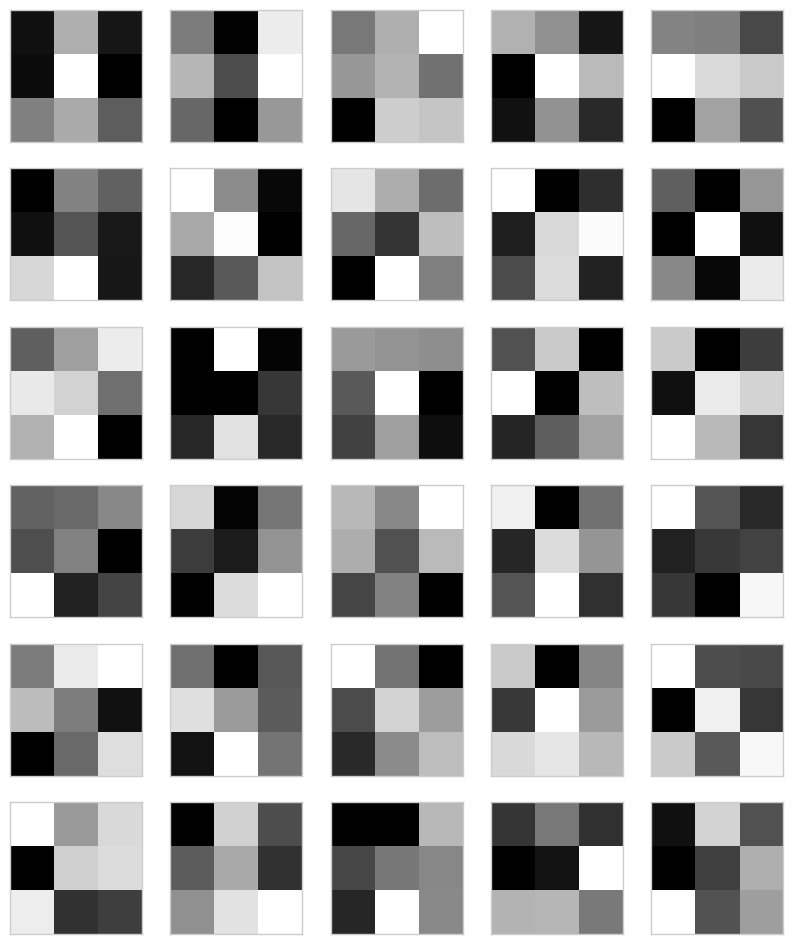

In [35]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

Nfilters_to_plot = 30

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print(f'1st {Nfilters_to_plot} filters in convolution layer 1:')
ncols = int(np.ceil(Nfilters_to_plot / 5))
fig, ax = plt.subplots(ncols,5, figsize=(10, 2*ncols))
axs = ax.flatten()
for i in range(Nfilters_to_plot):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

# Evaluate training process

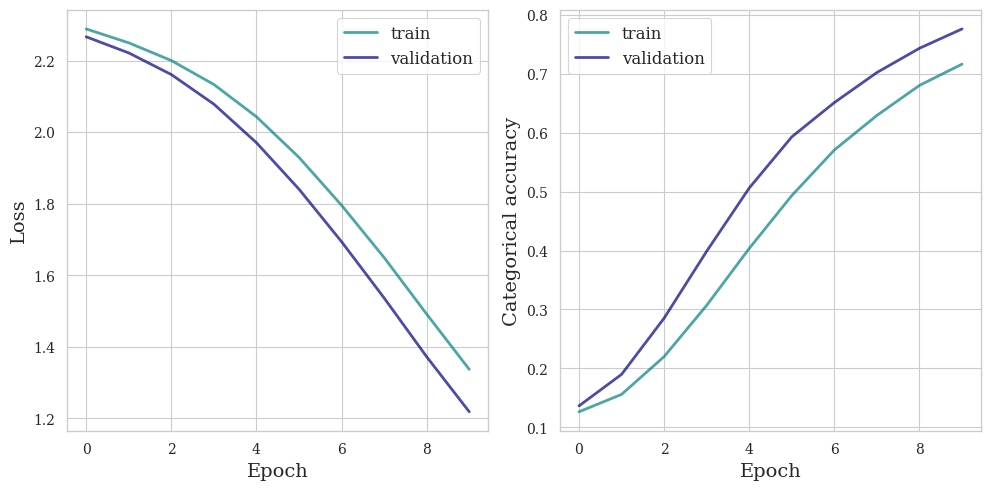

In [36]:
plot_training_results(history);

Evaluate your model on the validation data. 

In [37]:
# Predict on the validation set
val_prediction_probabilities = model.predict(val_images)
val_predictions = np.argmax(val_prediction_probabilities, axis=1)

# Calculate classification report
val_accuracy = accuracy_score(np.argmax(val_labels, axis = 1), val_predictions)
report = classification_report(np.argmax(val_labels, axis = 1), val_predictions)

print("\nClassification Report:\n", report)

250/250 [==============================] - 1s 4ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.89      0.83       777
           1       0.83      0.92      0.87       919
           2       0.84      0.82      0.83       819
           3       0.69      0.78      0.73       802
           4       0.85      0.64      0.73       767
           5       0.84      0.56      0.67       718
           6       0.70      0.87      0.77       758
           7       0.80      0.85      0.82       841
           8       0.78      0.71      0.75       788
           9       0.71      0.67      0.69       811

    accuracy                           0.78      8000
   macro avg       0.78      0.77      0.77      8000
weighted avg       0.78      0.78      0.77      8000



Calculate and plot confusion matrix

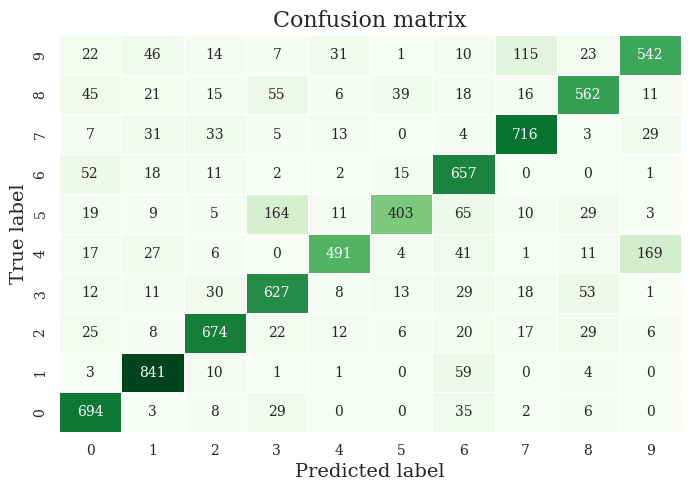

In [38]:
val_conf_matrix = confusion_matrix(y_true=np.argmax(val_labels, axis=1), y_pred=val_predictions)

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(val_conf_matrix, ax=ax, annot=True, 
            annot_kws={"size": 10}, fmt="d", linewidths=.5, 
            cbar=False, cmap='Greens'
            )

ax.invert_yaxis()
ax.set(ylabel='True label', xlabel='Predicted label', title='Confusion matrix')
fig.tight_layout()

## Evaluate the model on the unseen test data

In [39]:
# Predict on unseen test data
test_prediction_probabilities = model.predict(test_images)
test_predictions = np.argmax(test_prediction_probabilities, axis=1)

test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), test_predictions)
report = classification_report(np.argmax(test_labels, axis=1), test_predictions)
print("\nClassification Report:\n", report)

63/63 [==============================] - 0s 4ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.85       203
           1       0.84      0.90      0.87       216
           2       0.84      0.83      0.84       213
           3       0.71      0.77      0.74       208
           4       0.90      0.64      0.75       215
           5       0.81      0.63      0.71       174
           6       0.73      0.90      0.81       200
           7       0.79      0.84      0.82       187
           8       0.76      0.70      0.73       186
           9       0.68      0.71      0.69       198

    accuracy                           0.78      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



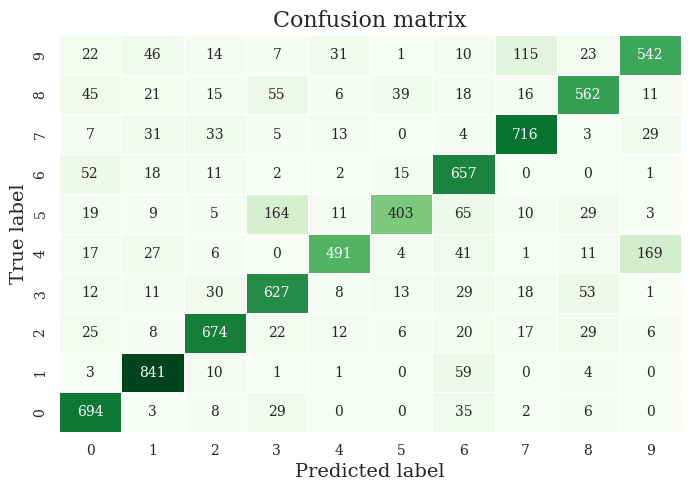

In [40]:
test_conf_matrix = confusion_matrix(y_true=np.argmax(test_labels, axis=1), y_pred=test_predictions)

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(val_conf_matrix, ax=ax, annot=True, 
            annot_kws={"size": 10}, fmt="d", linewidths=.5, 
            cbar=False, cmap='Greens'
            )

ax.invert_yaxis()
ax.set(ylabel='True label', xlabel='Predicted label', title='Confusion matrix')
fig.tight_layout()

# Inspection of predictions

#### Correctly predicted images

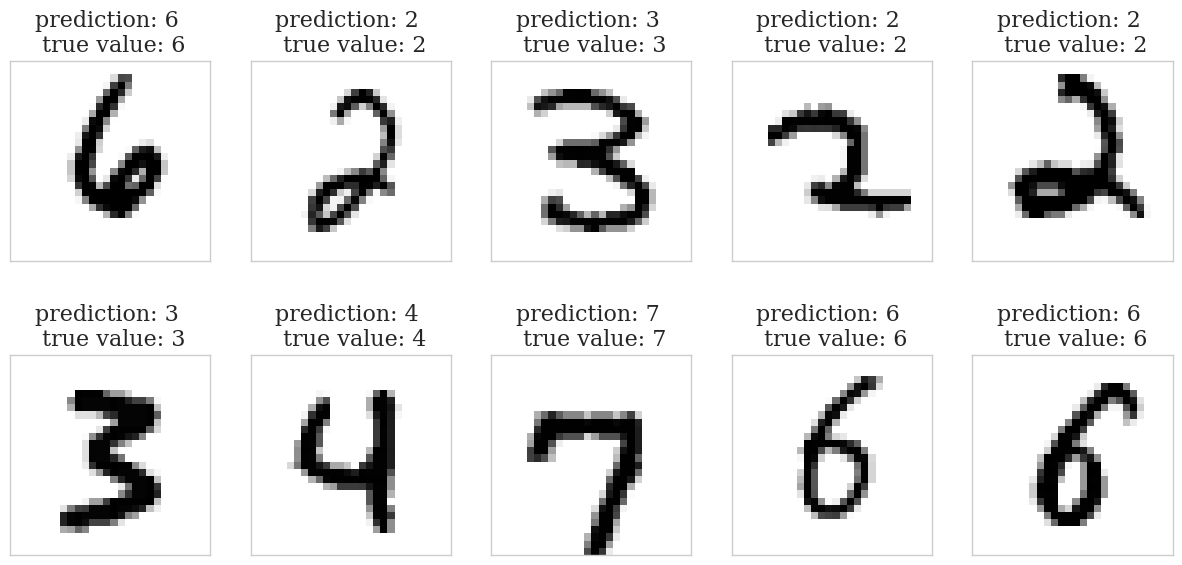

In [42]:
# show first Nimg images that were correctly predicted
Nimg = 10
correct_idx = np.where(test_predictions == np.argmax(test_labels, axis=1))[0]

nrows = int(np.ceil(Nimg/5))
fig, ax = plt.subplots(nrows,5, figsize=(15, 3.5*nrows))
ax = ax.flatten()   
for i in range(Nimg):
    ax[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    ax[i].set(title= f'prediction: {test_predictions[correct_idx[i]]} \n true value: {np.argmax(test_labels, axis=1)[correct_idx[i]]}',
              xticks = [], yticks = []
              )
    ax[i].grid(False)   

#### Wrongly predicted images

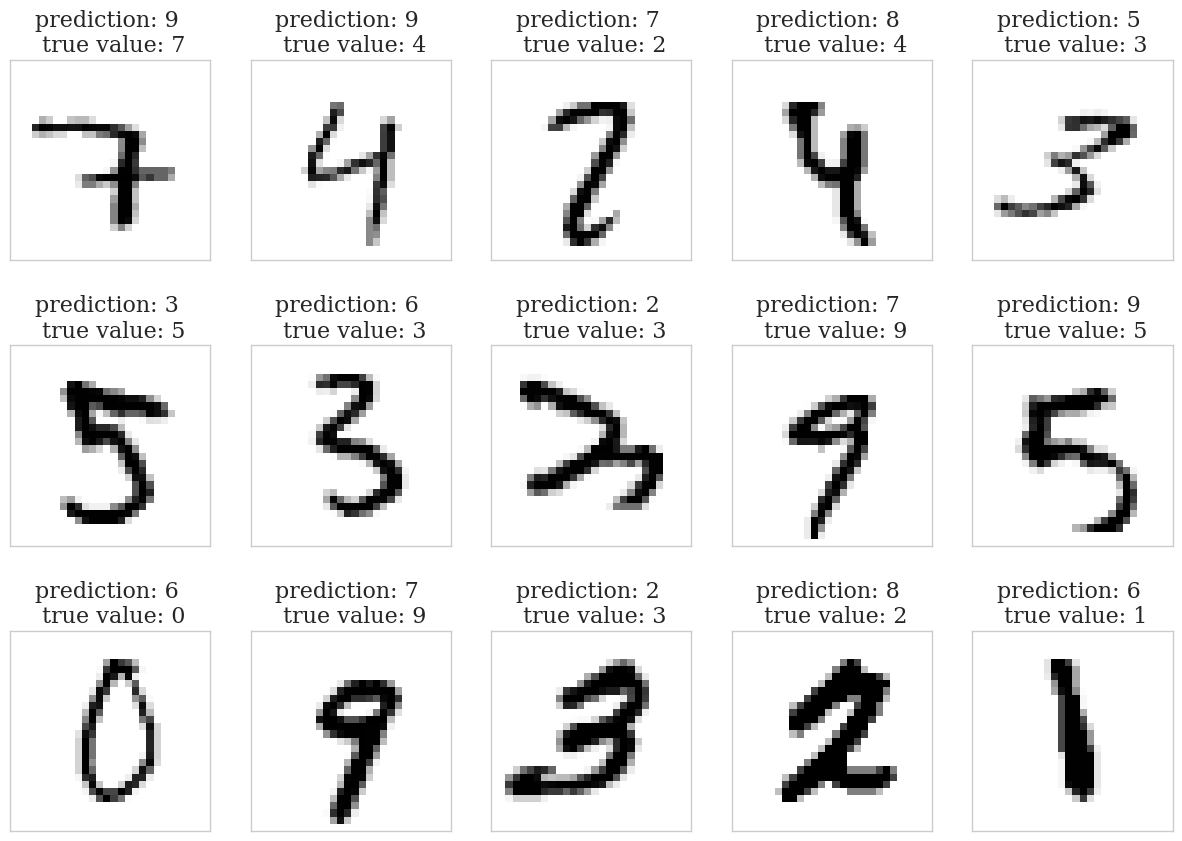

In [43]:
# show first Nimg images that were wrongly predicted
Nimg = 15
correct_idx = np.where(test_predictions != np.argmax(test_labels, axis=1))[0]

nrows = int(np.ceil(Nimg/5))
fig, ax = plt.subplots(nrows,5, figsize=(15, 3.5*nrows))
ax = ax.flatten()   
for i in range(Nimg):
    ax[i].imshow(test_images[correct_idx[i],:,:,0], cmap=plt.cm.binary)
    ax[i].set(title= f'prediction: {test_predictions[correct_idx[i]]} \n true value: {np.argmax(test_labels, axis=1)[correct_idx[i]]}',
              xticks = [], yticks = []
              )
    ax[i].grid(False)   

*************************************

# Exercises 

### Exercise 1: 

Go through this notebook step by step and make sure you understand each part, and draw the current architecture of the CNN model


### Exercise 2: 

Looking at the confusion matrix, which numbers has our model learned to identify accurately, and with which numbers is it struggling? From the confusion matrix and the wrongly predicted images above (you can plot more if you like), why do you think it is struggling to identify these numbers?

### Exercise 3: How accurate can you make your model?

The parameters used so far have been chosen simply to make training fast, and there is a lot of room for improvement!

Try getting as high an accurary as possible by making adjustments and tweaks as you see fit. Can you train a model to overcome the problems with identifying certain numbers that the current model has?

$\textit{You might consider}$:
* changing the number of epochs, batch size and/or learning rate
* changing the model architecture (Most importantly: the number of filters and the number and size of the dense layer(s). Secondarily: the kernel size, the number and dropout rate of dropout layers, the number and type (max or mean) pooling layers, the stride etc)